# Active Learning Guide

TBD.

## Setup

In [80]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset

In [3]:
TRAIN_RATIO = 0.2
BATCH_SIZE = 64

In [4]:
from data_utils import (
    build_resized_image_folder,
    build_paths_and_labels,
    train_test_val_pool_split,
    CustomDataset,
    IMAGENET_MEAN,
    IMAGENET_STD,
    visualize_batch,
    IMAGE_MIN_SIZE,
    train_transform,
    eval_transform,
)

In [5]:
# Resize images to 64px their smallest side and save to new folder.
# This will accelerate training, since the purpose is to show how active learning works.
dataset_root = Path("./data/flowers")
build_resized_image_folder(
    src_root=dataset_root / "train",
    dst_root=dataset_root / f"train_{IMAGE_MIN_SIZE}",
    min_side=IMAGE_MIN_SIZE,
    overwrite=False,
)

Processing images: 100%|██████████| 2751/2751 [00:03<00:00, 731.56it/s]

Done. Processed 2746 images. Wrote 0 resized images to: data\flowers\train_64


In [6]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

In [7]:
print(f"Number of paths: {len(paths)}")
print(f"Classes: {classe_names}")
print(f"Class to index mapping: {class_to_id}")
print(f"First path: {paths[0]}")
print(f"First label (int, id): {labels[0]}")
print(f"First label (str): {classe_names[labels[0]]}")

Number of paths: 2746
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
First path: data\flowers\train_64\daisy\10140303196_b88d3d6cec.jpg
First label (int, id): 0
First label (str): daisy


In [8]:
# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [9]:
print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Train size: 548
Val size: 276
Test size: 276
Pool size: 1646


In [10]:
# Auxiliary factory function to create DataLoaders
# If not Windows, set num_workers > 0 for faster data loading.
# If CUDA is available, set pin_memory=True for faster data transfer to GPU.
def make_loader(ds, batch_size=16, shuffle=False, num_workers=1, pin_memory=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

In [11]:
# Datasets and loaders
train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
test_ds = CustomDataset(paths, labels, test_idx,  transform=eval_transform)
pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
pool_loader = make_loader(pool_ds, batch_size=BATCH_SIZE, shuffle=False)

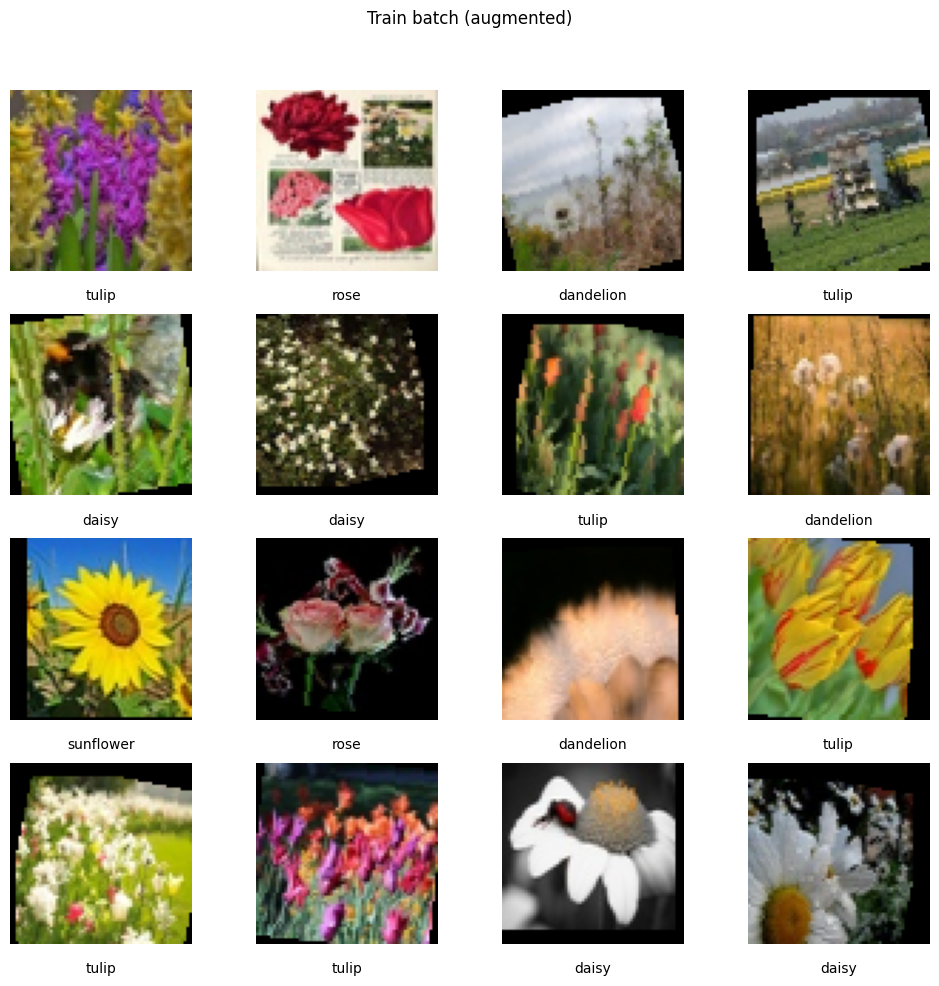

In [12]:
batch = next(iter(train_loader))
visualize_batch(batch, class_names=classe_names, title="Train batch (augmented)")

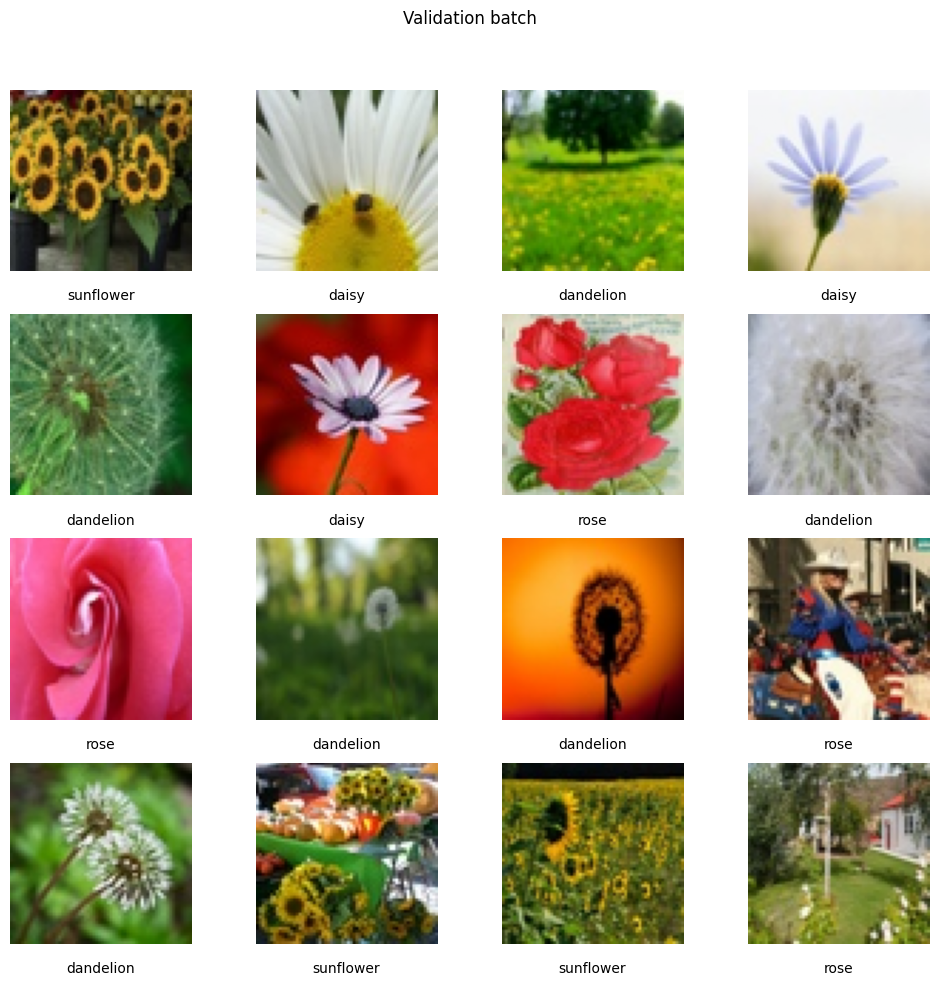

In [13]:
batch = next(iter(val_loader))
visualize_batch(batch, class_names=classe_names, title="Validation batch")

## Model Definition and Training Check

In [14]:
from model_utils import (
    SimpleCNN,
    TrainConfig,
    train,
    evaluate,
    plot_history,
    load_model,
    predict,
    predict_image,
    set_seed,
)

In [16]:
# Set seed for reproducibility
set_seed(42)

In [17]:
# model
model = SimpleCNN(num_classes=len(classe_names))

In [18]:
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projection): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=T

In [19]:
print(f"Model size: {model.size:,} parameters")

Model size: 2,192,389 parameters


In [20]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [21]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.109375

In [22]:
# Check that the classifier / feature vector switch works as expected
model.eval()
with torch.no_grad():
    raw_output = model(images, return_embeddings=False)
    print(raw_output.shape)

torch.Size([64, 5])


In [24]:
# Training Configuration
best_metric = "val_f1"  # "val_acc" | "val_loss" | "val_f1"
cfg = TrainConfig(
    num_classes=len(classe_names),
    epochs=20,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    out_dir="runs/flowers_cnn",
    run_name=f"train_ratio_{TRAIN_RATIO}",
    metric_for_best=best_metric,
    maximize_metric=False if "loss" in best_metric else True,
)

In [25]:
# Train the model!
history = train(model, train_loader, val_loader, cfg)

Training epochs:   5%|▌         | 1/20 [00:16<05:11, 16.40s/it]

Epoch 001/20 | train_loss=107.9643 train_acc=0.297 train_f1=0.278 | val_loss=9.9001 val_acc=0.377 val_f1=0.333 | lr=1.00e-03


Training epochs:  10%|█         | 2/20 [00:32<04:54, 16.37s/it]

Epoch 002/20 | train_loss=17.4870 train_acc=0.405 train_f1=0.395 | val_loss=8.7022 val_acc=0.362 val_f1=0.330 | lr=1.00e-03


Training epochs:  15%|█▌        | 3/20 [00:49<04:40, 16.51s/it]

Epoch 003/20 | train_loss=7.0894 train_acc=0.418 train_f1=0.402 | val_loss=3.2156 val_acc=0.359 val_f1=0.340 | lr=1.00e-03


Training epochs:  20%|██        | 4/20 [01:07<04:34, 17.13s/it]

Epoch 004/20 | train_loss=2.6979 train_acc=0.372 train_f1=0.360 | val_loss=1.7427 val_acc=0.362 val_f1=0.359 | lr=1.00e-03


Training epochs:  25%|██▌       | 5/20 [01:23<04:11, 16.76s/it]

Epoch 005/20 | train_loss=1.5725 train_acc=0.370 train_f1=0.368 | val_loss=1.6872 val_acc=0.366 val_f1=0.345 | lr=1.00e-03


Training epochs:  30%|███       | 6/20 [01:40<03:57, 16.94s/it]

Epoch 006/20 | train_loss=1.4517 train_acc=0.381 train_f1=0.346 | val_loss=1.6144 val_acc=0.366 val_f1=0.325 | lr=1.00e-03


Training epochs:  35%|███▌      | 7/20 [01:59<03:48, 17.58s/it]

Epoch 007/20 | train_loss=1.4755 train_acc=0.372 train_f1=0.355 | val_loss=1.5768 val_acc=0.362 val_f1=0.342 | lr=1.00e-03


Training epochs:  40%|████      | 8/20 [02:15<03:25, 17.12s/it]

Epoch 008/20 | train_loss=1.4175 train_acc=0.385 train_f1=0.360 | val_loss=1.5922 val_acc=0.384 val_f1=0.365 | lr=1.00e-03


Training epochs:  45%|████▌     | 9/20 [02:32<03:07, 17.02s/it]

Epoch 009/20 | train_loss=1.4177 train_acc=0.407 train_f1=0.395 | val_loss=1.6240 val_acc=0.420 val_f1=0.412 | lr=1.00e-03


Training epochs:  50%|█████     | 10/20 [02:59<03:20, 20.06s/it]

Epoch 010/20 | train_loss=1.3338 train_acc=0.434 train_f1=0.436 | val_loss=1.6520 val_acc=0.424 val_f1=0.421 | lr=1.00e-03


Training epochs:  55%|█████▌    | 11/20 [03:17<02:53, 19.26s/it]

Epoch 011/20 | train_loss=1.3363 train_acc=0.458 train_f1=0.459 | val_loss=1.6856 val_acc=0.420 val_f1=0.415 | lr=1.00e-03


Training epochs:  60%|██████    | 12/20 [03:37<02:36, 19.60s/it]

Epoch 012/20 | train_loss=1.3178 train_acc=0.445 train_f1=0.458 | val_loss=1.6153 val_acc=0.446 val_f1=0.448 | lr=1.00e-03


Training epochs:  65%|██████▌   | 13/20 [03:57<02:18, 19.72s/it]

Epoch 013/20 | train_loss=1.3423 train_acc=0.432 train_f1=0.443 | val_loss=1.6590 val_acc=0.489 val_f1=0.491 | lr=1.00e-03


Training epochs:  70%|███████   | 14/20 [04:16<01:57, 19.63s/it]

Epoch 014/20 | train_loss=1.3345 train_acc=0.456 train_f1=0.451 | val_loss=1.6825 val_acc=0.482 val_f1=0.481 | lr=1.00e-03


Training epochs:  75%|███████▌  | 15/20 [04:34<01:35, 19.15s/it]

Epoch 015/20 | train_loss=1.3098 train_acc=0.456 train_f1=0.447 | val_loss=1.5756 val_acc=0.457 val_f1=0.453 | lr=1.00e-03


Training epochs:  80%|████████  | 16/20 [04:51<01:14, 18.51s/it]

Epoch 016/20 | train_loss=1.3245 train_acc=0.451 train_f1=0.447 | val_loss=1.5987 val_acc=0.457 val_f1=0.452 | lr=1.00e-03


Training epochs:  85%|████████▌ | 17/20 [05:09<00:55, 18.33s/it]

Epoch 017/20 | train_loss=1.3197 train_acc=0.454 train_f1=0.445 | val_loss=1.5940 val_acc=0.482 val_f1=0.483 | lr=1.00e-03


Training epochs:  90%|█████████ | 18/20 [05:26<00:35, 17.96s/it]

Epoch 018/20 | train_loss=1.3339 train_acc=0.438 train_f1=0.425 | val_loss=1.5726 val_acc=0.457 val_f1=0.449 | lr=1.00e-03


Training epochs:  95%|█████████▌| 19/20 [05:45<00:18, 18.13s/it]

Epoch 019/20 | train_loss=1.2532 train_acc=0.465 train_f1=0.452 | val_loss=1.5726 val_acc=0.467 val_f1=0.459 | lr=1.00e-03


Training epochs: 100%|██████████| 20/20 [06:03<00:00, 18.18s/it]

Epoch 020/20 | train_loss=1.3230 train_acc=0.473 train_f1=0.463 | val_loss=1.5445 val_acc=0.471 val_f1=0.472 | lr=1.00e-03


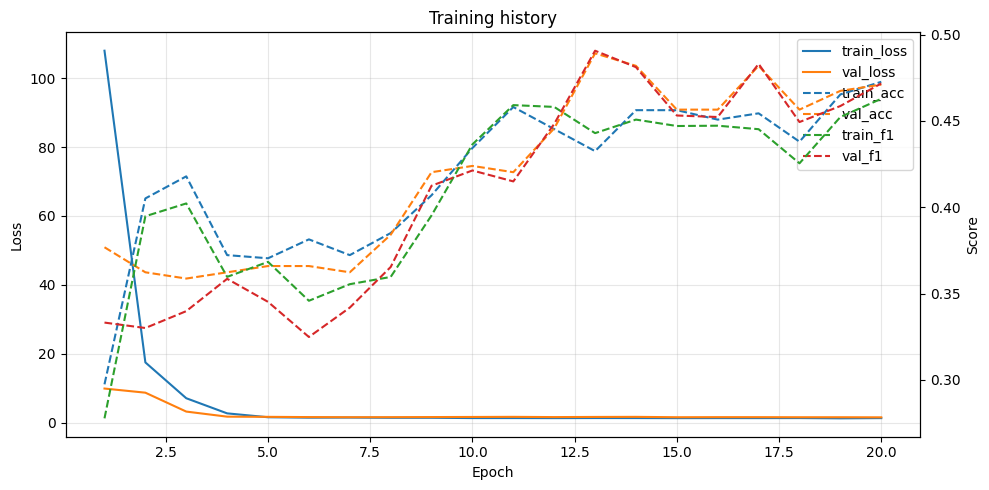

In [26]:
# Plot learning curves
plot_history(history)

In [31]:
# Evaluate best checkpoint
device = torch.device(cfg.device)
ckpt = load_model(Path(cfg.out_dir) / cfg.run_name / "best.pt", model, map_location=cfg.device)
test_metrics = evaluate(model.to(device), test_loader, device, num_classes=len(classe_names))

In [32]:
print(test_metrics)

{'test_loss': 1.6271411387816719, 'test_acc': 0.5181159420289855, 'test_f1': 0.5104970324625108}


In [33]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [34]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.484375

## Active Learning: Single Query

In [35]:
import numpy as np

from active_ml_utils import (
    TorchClassifierWrapper,
    compute_next_candidates,
    transfer_candidates_idx,
    SearchStrategy,
)

In [36]:
wrapper = TorchClassifierWrapper(
    model=model,
    pool_ds=pool_ds,
    batch_size=16,  # small for demo
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

In [37]:
X_small = np.array([[0], [3], [7], [10], [25]])
X_empty = np.empty((0,0))

In [38]:
X_small.shape

(5, 1)

In [39]:
X_empty.shape

(0, 0)

In [40]:
probs = wrapper.predict_proba(X_empty)
feats = wrapper.compute_embeddings(X_empty)

In [41]:
probs = wrapper.predict_proba(X_small)
feats = wrapper.compute_embeddings(X_small)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]


In [44]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0])

Shape: (5, 5)
First row probs: [5.8105792e-04 5.7648411e-03 1.3047220e-07 9.9365401e-01 1.2119942e-11]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        6.721676
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0

In [45]:
probs, feats = wrapper.predict_proba(X_small, return_embeddings=True)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


In [47]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0])

Shape: (5, 5)
First row probs: [5.8105792e-04 5.7648411e-03 1.3047220e-07 9.9365401e-01 1.2119942e-11]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        6.721676
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0

In [48]:
len(pool_ds)

1646

In [49]:
candidates_local_idx = compute_next_candidates(
    model=model,
    pool_ds=pool_ds,
    query_size=32,
    method="badge",  # "random", "least_confident", "margin_sampling", "entropy", "badge"
    seed=42,
    batch_size=16,
    device="cpu",
    num_workers=0,
    pin_memory=False,
    verbose=True,
)

predict_proba: 100%|██████████| 103/103 [00:05<00:00, 20.06it/s]


In [50]:
candidates_local_idx

[394,
 1039,
 772,
 471,
 134,
 77,
 343,
 1525,
 121,
 261,
 48,
 708,
 915,
 853,
 939,
 507,
 1036,
 1115,
 124,
 1048,
 1326,
 136,
 1327,
 1124,
 1442,
 1556,
 1339,
 1444,
 1004,
 79,
 313,
 399]

In [51]:
train_new_idx, pool_new_idx, candidates_global_idx = transfer_candidates_idx(
    train_idx=train_idx,
    pool_idx=pool_idx,
    candidates_idx=candidates_local_idx,
)

In [52]:
candidates_global_idx

[2383,
 1773,
 2351,
 301,
 1574,
 493,
 40,
 2296,
 2429,
 2259,
 2346,
 2476,
 1391,
 1068,
 2595,
 452,
 2329,
 1711,
 1606,
 2438,
 920,
 1210,
 2151,
 1006,
 1565,
 501,
 2717,
 983,
 2661,
 889,
 1154,
 1335]

In [53]:
print(f"len(train_idx): {len(train_idx)}")
print(f"len(train_new_idx): {len(train_new_idx)}")

len(train_idx): 548
len(train_new_idx): 580


## Active Learning: Experiments to Compare Strategies

In [92]:
import time
from typing import Optional
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
from tqdm import tqdm
from matplotlib.lines import Line2D

from data_utils import CustomDataset
from model_utils import SimpleCNN, TrainConfig, train, evaluate, load_model
from torch.utils.data import DataLoader

In [115]:
def plot_embeddings_2d(
    model,
    paths: list,
    labels: list,
    classe_names: list,
    train_idx: list[int],
    pool_idx: list[int],
    selected_idx: list[int],
    eval_transform,
    method: str = "umap",
    batch_size: int = 64,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    figsize: tuple = (14, 10),
    save_path: Optional[str] = None,
    title: Optional[str] = None,
) -> None:
    """Visualize embeddings in 2D using UMAP or t-SNE."""
    
    # Combine all indices we want to visualize
    all_idx = list(train_idx) + list(pool_idx) + list(selected_idx)
    
    # Remove duplicates while preserving order
    seen = set()
    all_idx_unique = []
    for idx in all_idx:
        if idx not in seen:
            seen.add(idx)
            all_idx_unique.append(idx)
    all_idx = all_idx_unique
    
    # Create dataset and loader
    all_ds = CustomDataset(paths, labels, all_idx, transform=eval_transform)
    all_loader = DataLoader(
        all_ds, batch_size=batch_size, shuffle=False, 
        num_workers=0, pin_memory=False
    )
    
    # Extract embeddings
    model = model.to(device)
    model.eval()
    
    embeddings_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch_x, batch_y in tqdm(all_loader, desc="Extracting embeddings"):
            batch_x = batch_x.to(device)
            _, feats = model(batch_x, return_embeddings=True)
            embeddings_list.append(feats.cpu().numpy())
            labels_list.extend(batch_y.numpy())
    
    embeddings = np.concatenate(embeddings_list, axis=0)
    labels_array = np.array(labels_list)
    
    # Reduce to 2D
    if method.lower() == "umap":
        reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, n_jobs=1)
    elif method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Create mapping from global idx to position
    idx_to_pos = {global_idx: i for i, global_idx in enumerate(all_idx)}
    
    # Split into groups
    train_positions = [idx_to_pos[idx] for idx in train_idx if idx in idx_to_pos]
    pool_positions = [idx_to_pos[idx] for idx in pool_idx if idx in idx_to_pos]
    selected_positions = [idx_to_pos[idx] for idx in selected_idx if idx in idx_to_pos]
    
    train_coords = embeddings_2d[train_positions]
    train_labels = labels_array[train_positions]
    
    pool_coords = embeddings_2d[pool_positions]
    pool_labels = labels_array[pool_positions]
    
    selected_coords = embeddings_2d[selected_positions]
    selected_labels = labels_array[selected_positions]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    num_classes = len(classe_names)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
    
    # 1. Pool (light, small)
    for class_idx in range(num_classes):
        mask = pool_labels == class_idx
        if mask.any():
            ax.scatter(
                pool_coords[mask, 0], pool_coords[mask, 1],
                c=[colors[class_idx]], s=20, alpha=0.3,
                marker='o', edgecolors='none', zorder=1
            )
    
    # 2. Training set (bold, medium)
    for class_idx in range(num_classes):
        mask = train_labels == class_idx
        if mask.any():
            ax.scatter(
                train_coords[mask, 0], train_coords[mask, 1],
                c=[colors[class_idx]], s=100, alpha=0.7,
                marker='o', edgecolors='black', linewidths=1, zorder=2
            )
    
    # 3. Selected samples (stars with red edges, largest)
    if len(selected_coords) > 0:
        for class_idx in range(num_classes):
            mask = selected_labels == class_idx
            if mask.any():
                ax.scatter(
                    selected_coords[mask, 0], selected_coords[mask, 1],
                    c=[colors[class_idx]], s=500, alpha=1.0,
                    marker='*', edgecolors='red', linewidths=4, zorder=3
                )
    
    ax.set_xlabel(f'{method.upper()} Dimension 1', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{method.upper()} Dimension 2', fontsize=12, fontweight='bold')
    
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Legend - Complete version with marker types AND class colors
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=5, label='Pool', alpha=0.3),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markeredgecolor='black', markeredgewidth=1,
               markersize=10, label='Training', alpha=0.7),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', 
               markeredgecolor='red', markeredgewidth=2,
               markersize=18, label=f'Selected ({len(selected_idx)})', alpha=1.0),
    ]
    
    # Add spacer and class colors
    legend_elements.append(Line2D([0], [0], color='none', label='', markersize=0))  # Spacer
    legend_elements.append(Line2D([0], [0], color='none', label='Classes:', markersize=0))
    
    for class_idx, class_name in enumerate(classe_names):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=colors[class_idx], markersize=8,
                   label=f'  {class_name}', alpha=0.8)
        )
    
    ax.legend(handles=legend_elements, loc='best', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()

In [ ]:
def evaluate_active_learning(
    # Data components
    paths: list,
    labels: list,
    classe_names: list,
    initial_train_idx: list[int],
    val_idx: list[int],
    test_idx: list[int],
    initial_pool_idx: list[int],
    train_transform,
    eval_transform,
    
    # Active learning parameters
    extension_ratio: float = 0.05,
    method: SearchStrategy = "badge",
    max_iterations: Optional[int] = None,
    
    # Training parameters
    epochs: int = 20,
    lr: float = 1e-3,
    batch_size: int = 64,
    
    # Model saving
    artifacts_dir: str = "runs/active_learning",
    run_name_slug: str = "exp",
    
    # Output
    output_csv: str = "active_learning_experiments.csv",
    
    # Runtime
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    num_workers: int = 0,
    pin_memory: bool = False,
    seed: int = 42,
    verbose: bool = True,
) -> dict:
    """
    Evaluate active learning by iteratively adding samples to the training set.
    
    Args:
        paths: List of all image paths
        labels: List of all labels (same length as paths)
        classe_names: List of class names
        initial_train_idx: Initial training set indices (global)
        val_idx: Validation set indices (global, remains fixed)
        test_idx: Test set indices (global, remains fixed)
        initial_pool_idx: Initial pool indices (global, decreases each iteration)
        train_transform: Transform for training data
        eval_transform: Transform for evaluation data
        extension_ratio: Fraction of pool to query each iteration (converted to query_size)
        method: Active learning strategy
        max_iterations: Maximum number of iterations (None = until pool is empty)
        epochs: Number of training epochs per iteration
        lr: Learning rate
        batch_size: Batch size for training
        artifacts_dir: Directory to save model checkpoints
        run_name_slug: Base name for run (will be modified with iteration info)
        output_csv: Path to output CSV file
        device: Device to train on
        num_workers: Number of workers for data loading
        pin_memory: Whether to pin memory for faster GPU transfer
        seed: Random seed
        verbose: Whether to print progress
        
    Returns:
        Dictionary with final statistics and history as pandas DataFrame
    """
    # Initialize output directory and CSV path
    artifacts_dir = Path(artifacts_dir)
    artifacts_dir.mkdir(parents=True, exist_ok=True)
    csv_path = artifacts_dir / Path(output_csv)
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Set seed for reproducibility
    set_seed(seed)
    
    # Helper function to create dataloaders
    def _make_loader(ds, batch_size=16, shuffle=False):
        return DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin_memory,
            drop_last=False,
        )
    
    # Initialize indices (make copies to avoid modifying original)
    train_idx = list(initial_train_idx)
    pool_idx = list(initial_pool_idx)
    
    # Calculate total samples
    total_samples = len(paths)
    
    # History tracking with DataFrame
    results_list = []
    iteration = 0
    
    if verbose:
        print(f"Starting active learning evaluation")
        print(f"Method: {method}")
        print(f"Extension ratio: {extension_ratio}")
        print(f"Initial train size: {len(train_idx)}")
        print(f"Val size: {len(val_idx)}")
        print(f"Test size: {len(test_idx)}")
        print(f"Initial pool size: {len(pool_idx)}")
        print(f"Output CSV: {output_csv}")
        print(f"Embeddings plots in directory: {artifacts_dir}")
        print("=" * 80)
    
    while len(pool_idx) > 0:
        if max_iterations is not None and iteration >= max_iterations:
            if verbose:
                print(f"Reached maximum iterations: {max_iterations}")
            break
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"Iteration {iteration}")
            print(f"Train size: {len(train_idx)}, Pool size: {len(pool_idx)}")
        
        # Calculate current train ratio (rounded to 2 decimals)
        current_train_ratio = round(len(train_idx) / total_samples, 2)

        # Create datasets
        train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
        val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
        test_ds = CustomDataset(paths, labels, test_idx, transform=eval_transform)
        pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)
        
        # Create dataloaders
        train_loader = _make_loader(train_ds, batch_size=batch_size, shuffle=False)
        val_loader = _make_loader(val_ds, batch_size=batch_size, shuffle=False)
        test_loader = _make_loader(test_ds, batch_size=batch_size, shuffle=False)
        
        # Initialize fresh model
        model = SimpleCNN(num_classes=len(classe_names))
        
        # Training configuration
        # method, iteration, train ratio in name for better tracking (2 decimal precision)
        run_name = f"{run_name_slug}_{method}_iteration_{iteration:03d}_train_ratio_{current_train_ratio:.2f}"
        cfg = TrainConfig(
            num_classes=len(classe_names),
            epochs=epochs,
            lr=lr,
            batch_size=batch_size,
            out_dir=artifacts_dir.as_posix(),
            run_name=run_name,
            metric_for_best="val_f1",
            maximize_metric=True,
            device=device,
            num_workers=num_workers,
            pin_memory=pin_memory,
            seed=seed,
            #seed=seed + iteration,  # Different seed per iteration
        )
        
        # Train the model
        if verbose:
            print(f"Training model for iteration {iteration}...")
        start_time = time.time()
        train_history = train(model, train_loader, val_loader, cfg)
        train_time = time.time() - start_time
        
        # Load best checkpoint and evaluate on test set
        best_ckpt_path = Path(cfg.out_dir) / cfg.run_name / "best.pt"
        ckpt = load_model(best_ckpt_path, model, map_location=cfg.device)
        model = model.to(torch.device(cfg.device))
        
        test_metrics = evaluate(model, test_loader, torch.device(cfg.device), num_classes=len(classe_names))
        
        # Get best epoch metrics from history
        best_epoch_idx = -1
        best_metric_value = ckpt.get("best_metric", None)
        
        # Find the best epoch in history
        for i, epoch_metrics in enumerate(train_history):
            if epoch_metrics.get(cfg.metric_for_best) == best_metric_value:
                best_epoch_idx = i
                break
        
        if best_epoch_idx == -1:
            best_epoch_idx = -1  # Use last epoch
        
        best_epoch_metrics = train_history[best_epoch_idx]
        
        # Prepare row data
        row_data = {
            "iteration": iteration,
            "method": method,
            "train_ratio": current_train_ratio,
            "extension_ratio": 0.0 if iteration == 0 else round(extension_ratio, 2),
            "train_size": len(train_idx),
            "val_size": len(val_idx),
            "test_size": len(test_idx),
            "pool_size": len(pool_idx),
            "query_size": 0,  # Will be updated after querying (0 for first iteration)
            "epochs": epochs,
            "lr": lr,
            "batch_size": batch_size,
            "train_time_sec": train_time,
            "train_loss": best_epoch_metrics["train_loss"],
            "train_acc": best_epoch_metrics["train_acc"],
            "train_f1": best_epoch_metrics["train_f1"],
            "val_loss": best_epoch_metrics["val_loss"],
            "val_acc": best_epoch_metrics["val_acc"],
            "val_f1": best_epoch_metrics["val_f1"],
            "test_loss": test_metrics["test_loss"],
            "test_acc": test_metrics["test_acc"],
            "test_f1": test_metrics["test_f1"],
            "best_metric": best_metric_value,
            "run_name": run_name,
        }
        
        if verbose:
            print(f"Results - Val F1: {best_epoch_metrics['val_f1']:.4f}, Test F1: {test_metrics['test_f1']:.4f}")
            print(f"Training time: {train_time:.2f}s")
        
        # Active learning: query next candidates
        # Query happens AFTER each iteration (including iteration 0)
        if len(pool_idx) > 0:
            query_size = max(1, int(total_samples * extension_ratio))
            
            if verbose:
                print(f"Querying {query_size} samples using {method}...")
            
            candidates_local_idx = compute_next_candidates(
                model=model,
                pool_ds=pool_ds,
                query_size=query_size,
                method=method,
                seed=seed,
                batch_size=batch_size,
                device=device,
                num_workers=num_workers,
                pin_memory=pin_memory,
                verbose=verbose,
            )
            
            # Save old train idx for visualization (before transfer)
            old_train_idx = list(train_idx)
            
            # Transfer candidates
            train_idx, pool_idx, candidates_global_idx = transfer_candidates_idx(
                train_idx=train_idx,
                pool_idx=pool_idx,
                candidates_idx=candidates_local_idx,
            )
            
            row_data["query_size"] = len(candidates_global_idx)
            
            if verbose:
                print(f"Added {len(candidates_global_idx)} samples to training set")
                plot_save_path = artifacts_dir / f"{run_name}_embedding_plot.png"
                plot_embeddings_2d(
                    model=model,
                    paths=paths,
                    labels=labels,
                    classe_names=classe_names,
                    train_idx=old_train_idx,
                    pool_idx=pool_idx,  # New pool (after removal)
                    selected_idx=candidates_global_idx,  # Newly selected
                    eval_transform=eval_transform,
                    method="umap",  # or "tsne"
                    batch_size=batch_size,
                    device=device,
                    save_path=str(plot_save_path),
                    title=f"Iteration {iteration} - {method.upper()} Selection"
                )
        elif iteration == 0:
            # First iteration: no querying yet, just evaluate baseline
            if verbose:
                print(f"Baseline iteration - no querying performed")
        
        # Add to results list
        results_list.append(row_data)
        
        # Convert to DataFrame and save to CSV
        new_row_df = pd.DataFrame([row_data])
        
        if csv_path.exists():
            # Load existing CSV and append new row
            existing_df = pd.read_csv(csv_path)
            df = pd.concat([existing_df, new_row_df], ignore_index=True)
        else:
            # First iteration - create new DataFrame
            df = new_row_df
        
        df.to_csv(csv_path, index=False)
        
        if verbose:
            print(f"CSV updated: {csv_path}")
        
        # Cleanup model to free memory and avoid re-using weights
        del model
        
        # Increase iteration counter
        iteration += 1
    
    # Final DataFrame
    #results_df = pd.DataFrame(results_list)
    results_df = pd.read_csv(csv_path)
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Active learning evaluation completed!")
        print(f"Total iterations: {iteration}")
        print(f"Final train size: {len(train_idx)}")
        print(f"Final pool size: {len(pool_idx)}")
        print(f"Results saved to: {csv_path}")
        print(f"\nFinal results summary:")
        print(results_df[['iteration', 'train_size', 'train_ratio', 'val_f1', 'test_f1']].to_string(index=False))
    
    return {
        "history_df": results_df,
        "final_train_idx": train_idx,
        "final_pool_idx": pool_idx,
        "num_iterations": iteration,
        "csv_path": str(csv_path),
    }

In [117]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

Starting active learning evaluation
Method: random
Extension ratio: 0.05
Initial train size: 548
Val size: 276
Test size: 276
Initial pool size: 1646
Output CSV: active_learning_random_experiments.csv

Iteration 0
Train size: 548, Pool size: 1646
Training model for iteration 0...


Training epochs:  33%|███▎      | 1/3 [00:04<00:08,  4.11s/it]

Epoch 001/3 | train_loss=4.3152 train_acc=0.246 train_f1=0.240 | val_loss=1.7183 val_acc=0.293 val_f1=0.231 | lr=1.00e-03


Training epochs:  67%|██████▋   | 2/3 [00:08<00:04,  4.08s/it]

Epoch 002/3 | train_loss=1.4927 train_acc=0.401 train_f1=0.389 | val_loss=1.3216 val_acc=0.435 val_f1=0.409 | lr=1.00e-03


Training epochs: 100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


Epoch 003/3 | train_loss=1.2131 train_acc=0.480 train_f1=0.477 | val_loss=1.2769 val_acc=0.478 val_f1=0.459 | lr=1.00e-03


Results - Val F1: 0.4589, Test F1: 0.5130
Training time: 12.31s
Querying 137 samples using random...
Added 137 samples to training set


Extracting embeddings: 100%|██████████| 35/35 [00:05<00:00,  5.98it/s]


Saved to: runs\active_learning_experiments\flowers_random_iteration_000_train_ratio_0.20_embedding_plot.png


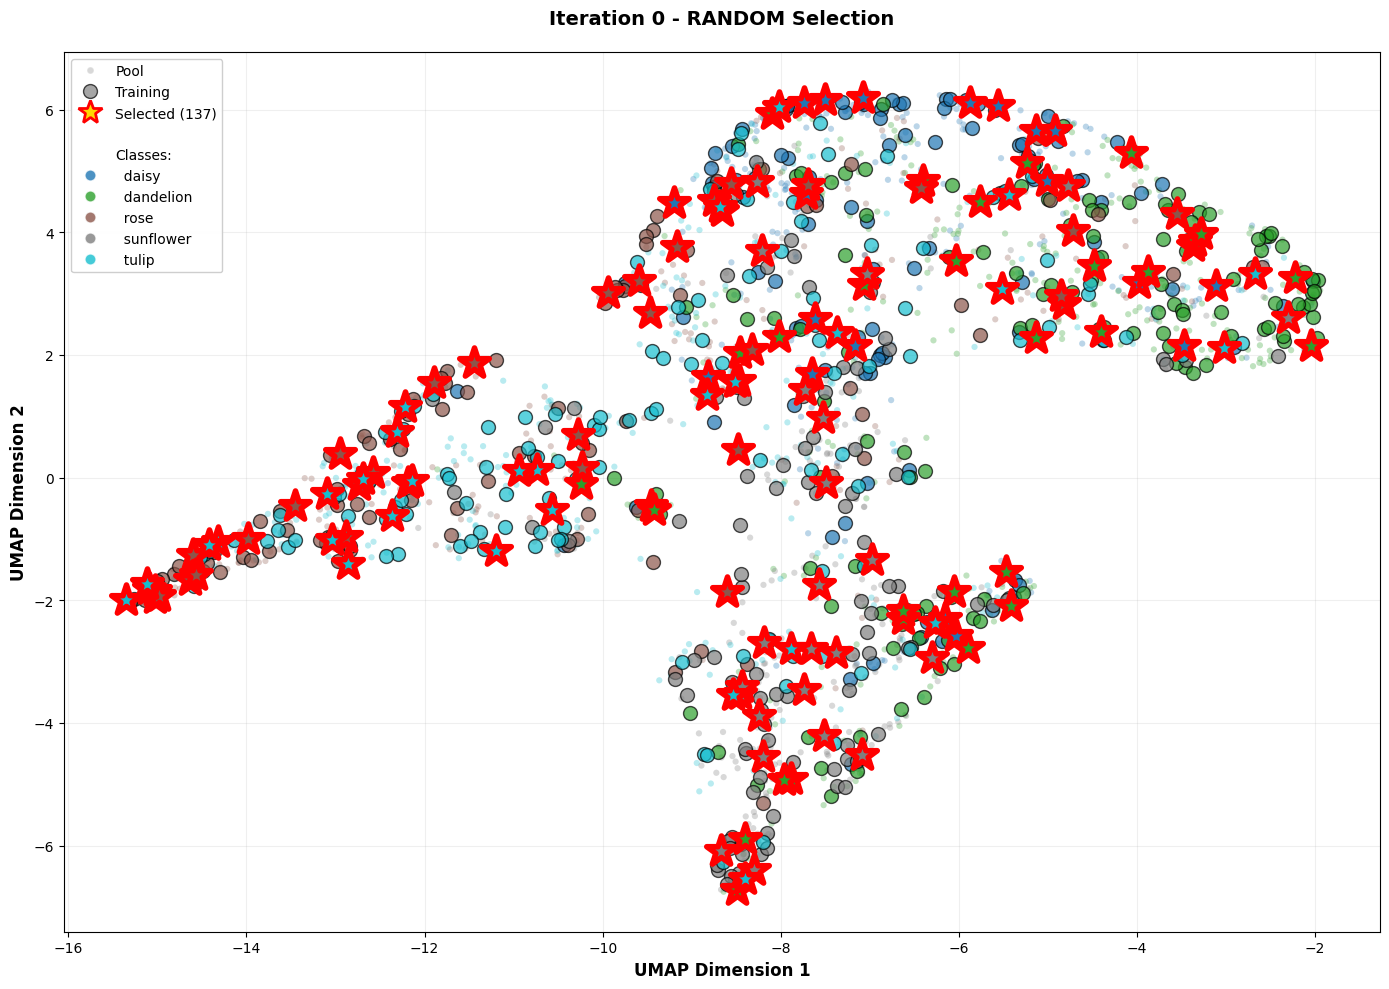

CSV updated: runs\active_learning_experiments\active_learning_random_experiments.csv

Iteration 1
Train size: 685, Pool size: 1509
Training model for iteration 1...


Training epochs:  33%|███▎      | 1/3 [00:04<00:09,  5.00s/it]

Epoch 001/3 | train_loss=4.1283 train_acc=0.261 train_f1=0.250 | val_loss=1.3906 val_acc=0.457 val_f1=0.409 | lr=1.00e-03


Training epochs:  67%|██████▋   | 2/3 [00:10<00:05,  5.10s/it]

Epoch 002/3 | train_loss=1.3886 train_acc=0.404 train_f1=0.368 | val_loss=1.2644 val_acc=0.478 val_f1=0.483 | lr=1.00e-03


Training epochs: 100%|██████████| 3/3 [00:15<00:00,  5.29s/it]


Epoch 003/3 | train_loss=1.2045 train_acc=0.495 train_f1=0.496 | val_loss=1.2075 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Results - Val F1: 0.4964, Test F1: 0.5354
Training time: 15.90s
Querying 137 samples using random...
Added 137 samples to training set


Extracting embeddings: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]


Saved to: runs\active_learning_experiments\flowers_random_iteration_001_train_ratio_0.25_embedding_plot.png


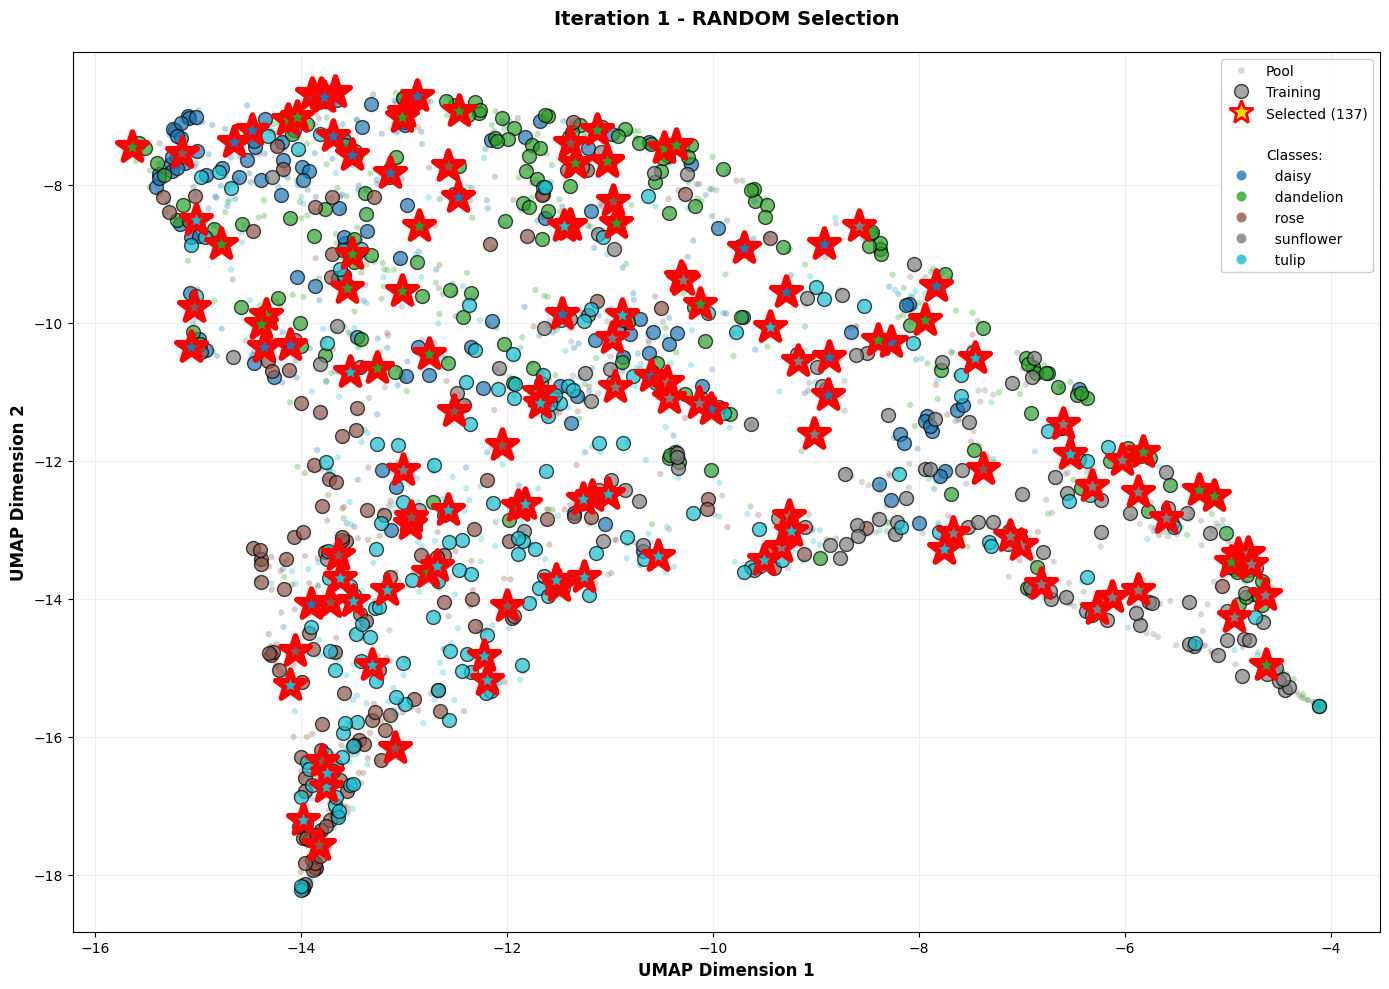

CSV updated: runs\active_learning_experiments\active_learning_random_experiments.csv

Iteration 2
Train size: 822, Pool size: 1372
Training model for iteration 2...


Training epochs:  33%|███▎      | 1/3 [00:06<00:12,  6.03s/it]

Epoch 001/3 | train_loss=3.2091 train_acc=0.311 train_f1=0.306 | val_loss=1.3830 val_acc=0.413 val_f1=0.336 | lr=1.00e-03


Training epochs:  67%|██████▋   | 2/3 [00:11<00:05,  5.67s/it]

Epoch 002/3 | train_loss=1.3428 train_acc=0.454 train_f1=0.445 | val_loss=1.2751 val_acc=0.457 val_f1=0.423 | lr=1.00e-03


Training epochs: 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


Epoch 003/3 | train_loss=1.1803 train_acc=0.509 train_f1=0.501 | val_loss=1.1654 val_acc=0.536 val_f1=0.532 | lr=1.00e-03


Results - Val F1: 0.5324, Test F1: 0.5426
Training time: 17.41s
Querying 137 samples using random...
Added 137 samples to training set


Extracting embeddings: 100%|██████████| 35/35 [00:05<00:00,  5.89it/s]


Saved to: runs\active_learning_experiments\flowers_random_iteration_002_train_ratio_0.30_embedding_plot.png


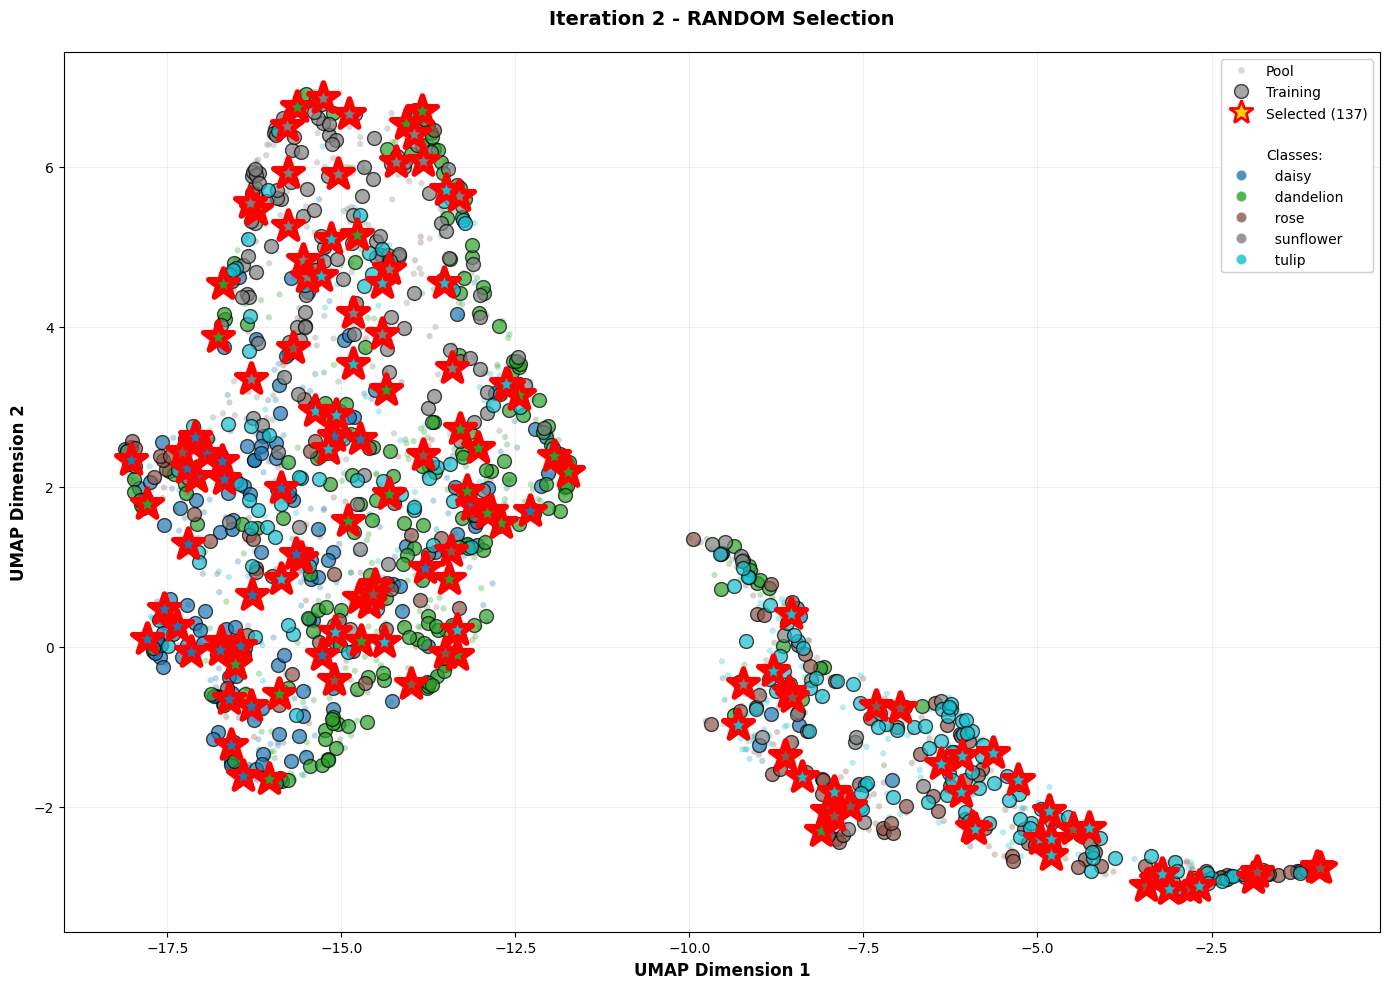

CSV updated: runs\active_learning_experiments\active_learning_random_experiments.csv
Reached maximum iterations: 3

Active learning evaluation completed!
Total iterations: 3
Final train size: 959
Final pool size: 1235
Results saved to: runs\active_learning_experiments\active_learning_random_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         548         0.20 0.458873 0.512965
         1         685         0.25 0.496405 0.535444
         2         822         0.30 0.532434 0.542640
         0         548         0.20 0.458873 0.512965
         0         548         0.20 0.458873 0.512965
         1         685         0.25 0.496405 0.535444
         2         822         0.30 0.532434 0.542640


In [119]:
method = "random"  # "random", "least_confident", "margin_sampling", "entropy", "badge"
results = evaluate_active_learning(
    # Data components
    paths=paths,
    labels=labels,
    classe_names=classe_names,
    initial_train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    initial_pool_idx=pool_idx,
    train_transform=train_transform,
    eval_transform=eval_transform,
    
    # Active learning parameters
    extension_ratio=0.05,
    method=method,  # "random", "least_confident", "margin_sampling", "entropy", "badge"
    max_iterations=3,  # Set to None to run until pool is empty
    
    # Training parameters
    epochs=3,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    
    # Model saving
    artifacts_dir="runs/active_learning_experiments",
    run_name_slug="flowers",
    
    # Output
    output_csv=f"active_learning_{method}_experiments.csv",
    
    # Runtime
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    pin_memory=False,
    seed=42,
    verbose=True,
)

In [120]:
def run_multiple_experiments(
    paths,
    labels,
    classe_names,
    initial_train_idx,
    val_idx,
    test_idx,
    initial_pool_idx,
    train_transform,
    eval_transform,
    methods: list[SearchStrategy] = ["random", "least_confident", "margin_sampling", "entropy", "badge"],
    extension_ratio: float = 0.05,
    artifacts_dir: str = "runs/active_learning_experiments",
    **kwargs
) -> dict:
    """
    Run active learning experiments with multiple methods.
    
    Each method will have its own CSV file and all results are combined
    into a single CSV for comparison.
    
    Args:
        paths: List of all image paths
        labels: List of all labels
        classe_names: List of class names
        initial_train_idx: Initial training set indices
        val_idx: Validation set indices
        test_idx: Test set indices
        initial_pool_idx: Initial pool indices
        train_transform: Transform for training data
        eval_transform: Transform for evaluation data
        methods: List of active learning methods to compare
        extension_ratio: Fraction of pool to query each iteration
        artifacts_dir: Directory to save all results (models + CSVs)
        **kwargs: Additional arguments passed to evaluate_active_learning
        
    Returns:
        Dictionary with results for each method and combined DataFrame
    """
    all_results = {}
    all_dfs = []
    
    artifacts_path = Path(artifacts_dir)
    artifacts_path.mkdir(parents=True, exist_ok=True)
    
    for method in methods:
        print(f"\n{'#'*80}")
        print(f"# Running experiment with method: {method}")
        print(f"{'#'*80}\n")
        
        # CSV filename
        output_csv = f"active_learning_{method}_experiments.csv"

        results = evaluate_active_learning(
            paths=paths,
            labels=labels,
            classe_names=classe_names,
            initial_train_idx=initial_train_idx,
            val_idx=val_idx,
            test_idx=test_idx,
            initial_pool_idx=initial_pool_idx,
            train_transform=train_transform,
            eval_transform=eval_transform,
            extension_ratio=extension_ratio,
            method=method,
            output_csv=output_csv,
            artifacts_dir=artifacts_dir,
            **kwargs
        )
        
        all_results[method] = results
        all_dfs.append(results["history_df"])
    
    # Combine all results into a single DataFrame
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_csv = artifacts_path / "active_learning_all_experiments.csv"
    combined_df.to_csv(combined_csv, index=False)
    
    print(f"\n{'='*80}")
    print(f"All experiments completed!")
    print(f"Combined results saved to: {combined_csv}")
    
    return {
        "results_by_method": all_results,
        "combined_df": combined_df,
        "combined_csv": str(combined_csv),
    }

In [121]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.05, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [122]:
print(f"Initial Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Initial Train size: 137
Val size: 276
Test size: 276
Pool size: 2057


In [ ]:
# Run experiments with all 5 methods
all_results = run_multiple_experiments(
    # Required data arguments
    paths=paths,
    labels=labels,
    classe_names=classe_names,
    initial_train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    initial_pool_idx=pool_idx,
    train_transform=train_transform,
    eval_transform=eval_transform,
    
    # Active learning parameters
    methods=["random", "least_confident", "margin_sampling", "entropy", "badge"],
    extension_ratio=0.03,
    
    # Additional arguments passed via kwargs to evaluate_active_learning
    max_iterations=20,  # None: Run until pool is empty (or set a number like 10)
    epochs=30,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    artifacts_dir="runs/active_learning_experiments_5",
    run_name_slug="flowers",
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    pin_memory=False,
    seed=42,
    verbose=True,
)

# Access results
print(f"\nAll experiments completed!")
print(f"Combined results: {all_results['combined_csv']}")

# View combined DataFrame
combined_df = all_results['combined_df']
print("\nFirst few rows:")
print(combined_df.head(10))

# Access individual method results
for method, result in all_results['results_by_method'].items():
    print(f"\n{method}: {result['num_iterations']} iterations")
    print(f"  CSV: {result['csv_path']}")


################################################################################
# Running experiment with method: random
################################################################################

Starting active learning evaluation
Method: random
Extension ratio: 0.03
Initial train size: 137
Val size: 276
Test size: 276
Initial pool size: 2057
Output CSV: active_learning_random_experiments.csv

Iteration 0
Train size: 137, Pool size: 2057
Training model for iteration 0...


Training epochs:   3%|▎         | 1/30 [00:03<01:28,  3.05s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:12,  2.58s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<00:59,  2.20s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


In [ ]:
all_results.keys()

dict_keys(['results_by_method', 'combined_df', 'combined_csv'])

In [ ]:
df_all = all_results["combined_df"]

In [ ]:
df_all.shape

(100, 24)

In [ ]:
df_all.head()

iteration  method  train_ratio  extension_ratio  train_size  val_size  \
0          0  random         0.05             0.00         137       276   
1          1  random         0.08             0.03         219       276   
2          2  random         0.11             0.03         301       276   
3          3  random         0.14             0.03         383       276   
4          4  random         0.17             0.03         465       276   

   test_size  pool_size  query_size  epochs  ...  train_acc  train_f1  \
0        276       2057          82      30  ...   0.810219  0.809659   
1        276       1975          82      30  ...   0.547945  0.548609   
2        276       1893          82      30  ...   0.780731  0.776968   
3        276       1811          82      30  ...   0.772846  0.766826   
4        276       1729          82      30  ...   0.780645  0.776498   

   val_loss   val_acc    val_f1  test_loss  test_acc   test_f1  best_metric  \
0  1.425612  0.539855  0.541261   1.397563  0.528986  0.527085     0.541261   
1  1.198762  0.510870  0.504526   1.162622  0.525362  0.522628     0.504526   
2  1.124648  0.626812  0.626225   1.113713  0.605072  0.598690     0.626225   
3  1.107416  0.630435  0.627501   1.152539  0.634058  0.629819     0.627501   
4  1.088321  0.634058  0.631076   1.117686  0.626812  0.619523     0.631076   

                                        run_name  
0  flowers_random_iteration_000_train_ratio_0.05  
1  flowers_random_iteration_001_train_ratio_0.08  
2  flowers_random_iteration_002_train_ratio_0.11  
3  flowers_random_iteration_003_train_ratio_0.14  
4  flowers_random_iteration_004_train_ratio_0.17  

[5 rows x 24 columns]

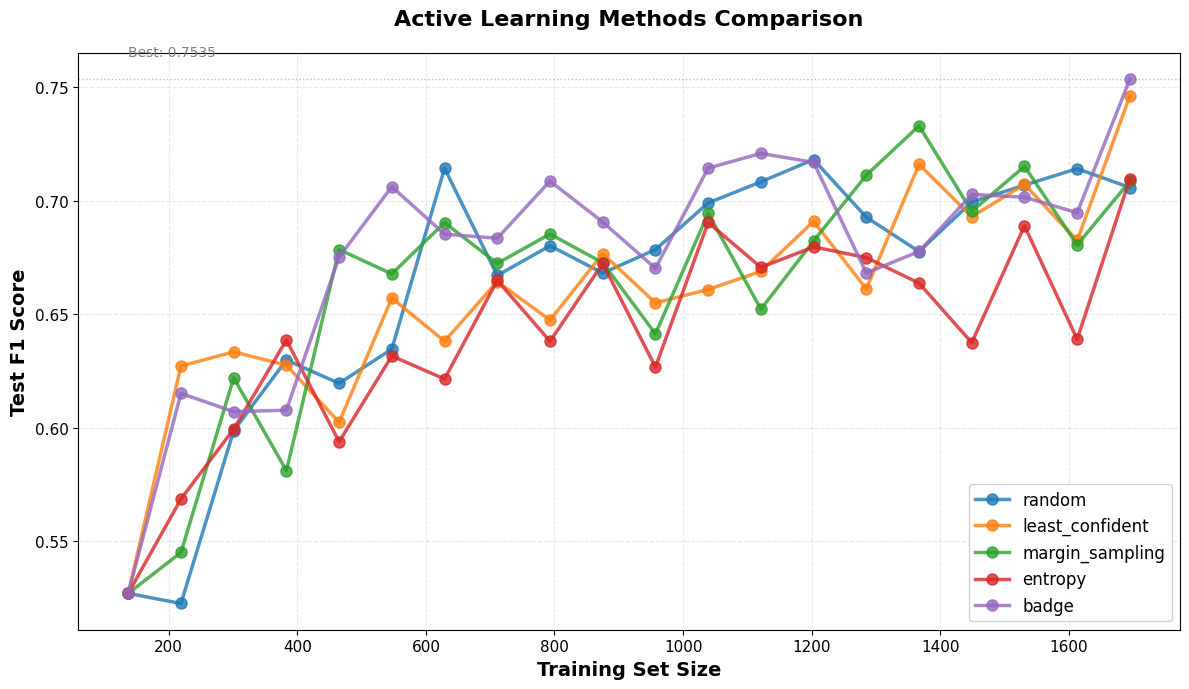


Final Performance (Last Iteration):
         method  train_size  test_f1  test_acc
          badge        1695 0.753496  0.753623
least_confident        1695 0.746111  0.746377
        entropy        1695 0.709670  0.710145
margin_sampling        1695 0.708528  0.710145
         random        1695 0.705711  0.706522


In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each method
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    ax.plot(method_df['train_size'], method_df['test_f1'], 
            marker='o', linewidth=2.5, markersize=8, label=method, alpha=0.8)

# Styling
ax.set_xlabel('Training Set Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
ax.set_title('Active Learning Methods Comparison', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=11)

# Add some context
ax.axhline(y=df_all['test_f1'].max(), color='gray', linestyle=':', alpha=0.5, linewidth=1)
ax.text(df_all['train_size'].min(), df_all['test_f1'].max() + 0.01, 
        f'Best: {df_all["test_f1"].max():.4f}', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFinal Performance (Last Iteration):")
final_results = df_all.groupby('method').tail(1)[['method', 'train_size', 'test_f1', 'test_acc']].sort_values('test_f1', ascending=False)
print(final_results.to_string(index=False))

Number of iterations per method:
method
badge              20
entropy            20
least_confident    20
margin_sampling    20
random             20
Name: iteration, dtype: int64


Performance progression:

random:
 iteration  train_size  train_ratio  test_f1  test_acc
         0         137         0.05 0.527085  0.528986
         1         219         0.08 0.522628  0.525362
         2         301         0.11 0.598690  0.605072
         3         383         0.14 0.629819  0.634058
         4         465         0.17 0.619523  0.626812
         5         547         0.20 0.634621  0.637681
         6         629         0.23 0.714164  0.713768
         7         711         0.26 0.667017  0.666667
         8         793         0.29 0.680109  0.681159
         9         875         0.32 0.668071  0.670290
        10         957         0.35 0.678416  0.677536
        11        1039         0.38 0.698946  0.699275
        12        1121         0.41 0.708229  0.706522
        13    

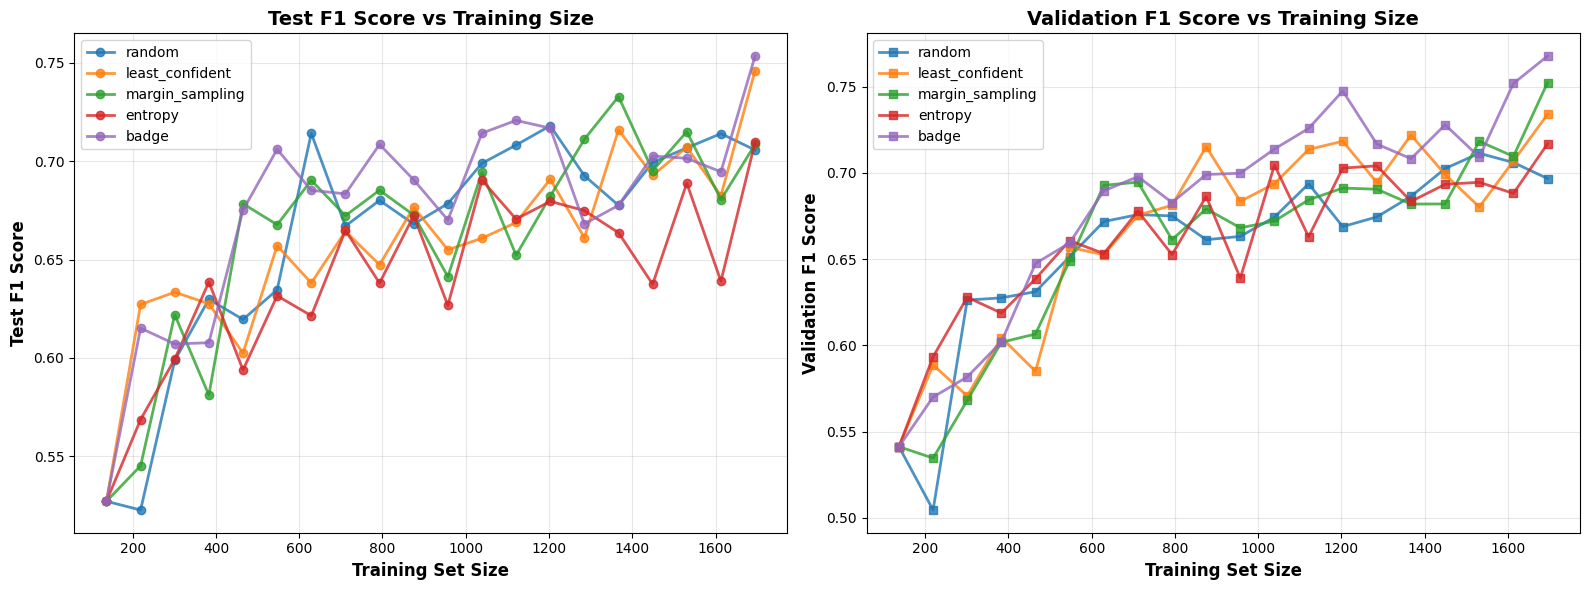



Method ranking by iteration (based on test_f1):

Iteration 0 (train_size = 137):
         method  test_f1
         random 0.527085
least_confident 0.527085
margin_sampling 0.527085
        entropy 0.527085
          badge 0.527085

Iteration 1 (train_size = 219):
         method  test_f1
least_confident 0.627165
          badge 0.615119
        entropy 0.568625
margin_sampling 0.545086
         random 0.522628

Iteration 2 (train_size = 301):
         method  test_f1
least_confident 0.633394
margin_sampling 0.621933
          badge 0.607060
        entropy 0.599373
         random 0.598690

Iteration 3 (train_size = 383):
         method  test_f1
        entropy 0.638589
         random 0.629819
least_confident 0.627531
          badge 0.607720
margin_sampling 0.581109

Iteration 4 (train_size = 465):
         method  test_f1
margin_sampling 0.678412
          badge 0.675149
         random 0.619523
least_confident 0.602406
        entropy 0.593856

Iteration 5 (train_size = 547):
  

In [ ]:
# Check the details
print("Number of iterations per method:")
print(df_all.groupby('method')['iteration'].max() + 1)

print("\n\nPerformance progression:")
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('iteration')
    print(f"\n{method}:")
    print(method_df[['iteration', 'train_size', 'train_ratio', 'test_f1', 'test_acc']].to_string(index=False))

# Plot with more detail - show val_f1 vs test_f1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test F1
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    axes[0].plot(method_df['train_size'], method_df['test_f1'], 
                marker='o', linewidth=2, markersize=6, label=method, alpha=0.8)

axes[0].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Test F1 Score', fontsize=12, fontweight='bold')
axes[0].set_title('Test F1 Score vs Training Size', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Validation F1
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    axes[1].plot(method_df['train_size'], method_df['val_f1'], 
                marker='s', linewidth=2, markersize=6, label=method, alpha=0.8)

axes[1].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('Validation F1 Score vs Training Size', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison at each iteration
print("\n\nMethod ranking by iteration (based on test_f1):")
for iter_num in sorted(df_all['iteration'].unique()):
    iter_df = df_all[df_all['iteration'] == iter_num][['method', 'test_f1']].sort_values('test_f1', ascending=False)
    print(f"\nIteration {iter_num} (train_size = {df_all[df_all['iteration']==iter_num]['train_size'].iloc[0]}):")
    print(iter_df.to_string(index=False))